<img src="./Espresso-Coffee-Beans-Market.jpg">

<h1><center>☕Coffee sales prediction☕</center></h1>

# 1. Introduction

We recorded a lot of data during the first year of our chain. We are now going to analyze them to try to predict the sales we will make in the next few days. Enjoy ! 🤓


### Libraries 📚⬇

In [23]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(22, 11)})
sns.set_context("poster")

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# 2. The .csv files 📁

> 📌**Note**:
* `Items.csv` contains information about the things we sell in our store. Spoiler alert it's almost exclusively food and drinks.
* `Sales.csv` contains a list of the transactions made during the last year.

In [2]:
#data
items = pd.read_csv("./sales data/Items.csv", sep = ';', header = 1)
data = pd.read_csv("./sales data/Sales.csv", sep = ';', header = 1)

## Items 🥞

In [3]:
#Check items
items.head()

,Produit,Sweet / Savory,Drink / Food,Hot / Cold,Allergènes,Price
0,Pancake vegan,Sweet,Food,Hot,NaN,4
1,Pancake,Sweet,Food,Hot,"Dairy, Eggs",4
2,Nutella panini,Sweet,Food,Hot,Nuts,3
3,Waffles,Sweet,Food,Hot,"Dairy, Eggs",3
4,Cinnamon roll,Sweet,Food,Cold,"Nuts, Eggs, Dairy",4


In [4]:
print("There is actually", items.shape[0], "different items in the dataset")

There is actually 31 different items in the dataset


## Transactions 💳

In [5]:
#Check data
data.head()

,TransactionNo,Items,DateTime,Daypart,DayType
0,1,Coffee,2016-10-30 09:58:11,Morning,Weekend
1,2,Pancake vegan,2016-10-30 10:05:34,Morning,Weekend
2,2,Pancake vegan,2016-10-30 10:05:34,Morning,Weekend
3,3,Cappucino,2016-10-30 10:07:57,Morning,Weekend
4,3,Nutella panini,2016-10-30 10:07:57,Morning,Weekend


In [6]:
#Dates
data['DateTime'] = pd.to_datetime(data.DateTime, format = '%Y-%m-%d %H:%M:%S')
data['Year'] = data['DateTime'].dt.year 
data['Month'] = data['DateTime'].dt.month
data['BigDate'] = data['DateTime'].dt.date
data['Date'] = data['DateTime'].dt.to_period('m')
data['Date'] = data['Date'].dt.to_timestamp()

data.head()

,TransactionNo,Items,DateTime,Daypart,DayType,Year,Month,BigDate,Date
0,1,Coffee,2016-10-30 09:58:11,Morning,Weekend,2016,10,2016-10-30,2016-10-01
1,2,Pancake vegan,2016-10-30 10:05:34,Morning,Weekend,2016,10,2016-10-30,2016-10-01
2,2,Pancake vegan,2016-10-30 10:05:34,Morning,Weekend,2016,10,2016-10-30,2016-10-01
3,3,Cappucino,2016-10-30 10:07:57,Morning,Weekend,2016,10,2016-10-30,2016-10-01
4,3,Nutella panini,2016-10-30 10:07:57,Morning,Weekend,2016,10,2016-10-30,2016-10-01


# 3. Join datasets

We will join the two dataset to have a price to each transactions.

In [7]:
# Rename to merge
items.rename(columns={'Produit':'Items'}, inplace=True)

In [8]:
data.shape

(20507, 9)

In [9]:
# Merge (inner)
df = pd.merge(data, items, on='Items', how='inner')
df = df.drop(columns=['TransactionNo', 'Sweet / Savory', 'Drink / Food', 'Hot / Cold', 'Allergènes'])
df.head()

,Items,DateTime,Daypart,DayType,Year,Month,BigDate,Date,Price
0,Coffee,2016-10-30 09:58:11,Morning,Weekend,2016,10,2016-10-30,2016-10-01,2
1,Coffee,2016-10-30 10:13:03,Morning,Weekend,2016,10,2016-10-30,2016-10-01,2
2,Coffee,2016-10-30 10:13:03,Morning,Weekend,2016,10,2016-10-30,2016-10-01,2
3,Coffee,2016-10-30 10:19:12,Morning,Weekend,2016,10,2016-10-30,2016-10-01,2
4,Coffee,2016-10-30 10:20:51,Morning,Weekend,2016,10,2016-10-30,2016-10-01,2


In [10]:
df.shape

(20507, 9)

In [11]:
#Groups
sales = df.groupby(by='BigDate', as_index=False).sum()
dataByDate = df.groupby(by='BigDate').sum()
dataByMonth = df.groupby(by=['Year','Month']).sum()
dataByItem = df.groupby(by='Items', as_index=False)

sales = sales.drop(columns=['Year','Month'])
sales.head()

,BigDate,Price
0,2016-01-11,409
1,2016-01-12,228
2,2016-02-11,494
3,2016-02-12,301
4,2016-03-11,596


In [12]:
time = []
day = 0
sales['Time'] = 1
for i in range(len(sales) - 1):
    sales.loc[i, 'Time'] = day
    day += (sales.loc[i+1, 'BigDate'] - sales.loc[i, 'BigDate']).days
sales.loc[len(sales) - 1, 'Time'] = day
df = df.sort_values(by="BigDate")
sales.set_index('BigDate', inplace=True)
sales.tail()

,Price,Time
BigDate,,
2017-11-02,560,661
2017-11-03,631,662
2017-12-01,236,690
2017-12-02,342,691
2017-12-03,423,692


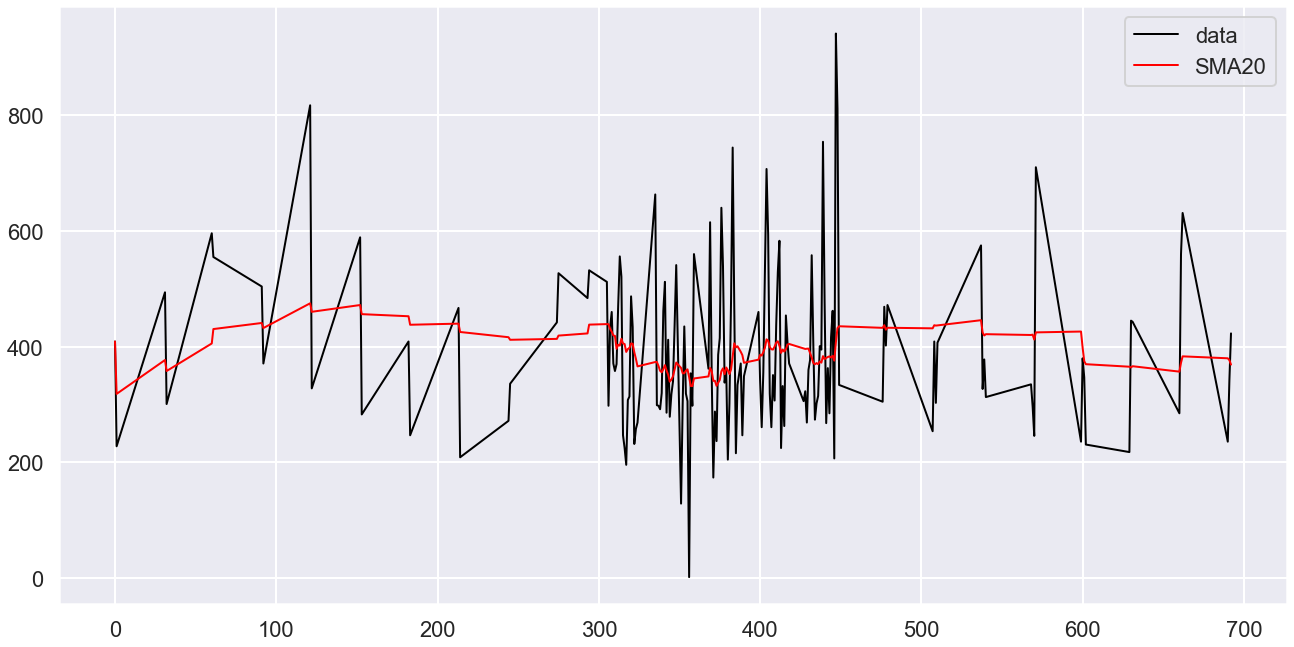

In [24]:
sales['SMA20'] = sales.Price.rolling(20, min_periods=1).mean()
x = sales['Time'].to_numpy()
y_SMA = sales['SMA20'].to_numpy()
y = sales['Price'].to_numpy()

plt.plot(x, y, color="black", linewidth=2, label="data")
plt.plot(x, y_SMA, color="red", linewidth=2, label="SMA20")
plt.legend(loc="best")

# 4. Prediction Model 📈

## Data

In [28]:
y = sales['SMA20'].to_numpy()
x = sales['Time'].to_numpy()
last_value = x[-1]
for i in range(20):
    last_value += 5
    x = np.append(x, last_value)
print(len(x))
X = []
for i in range(len(x)):
    X.append([x[i]])

X_unknown = X[-20:]
X = X[:-20]

179


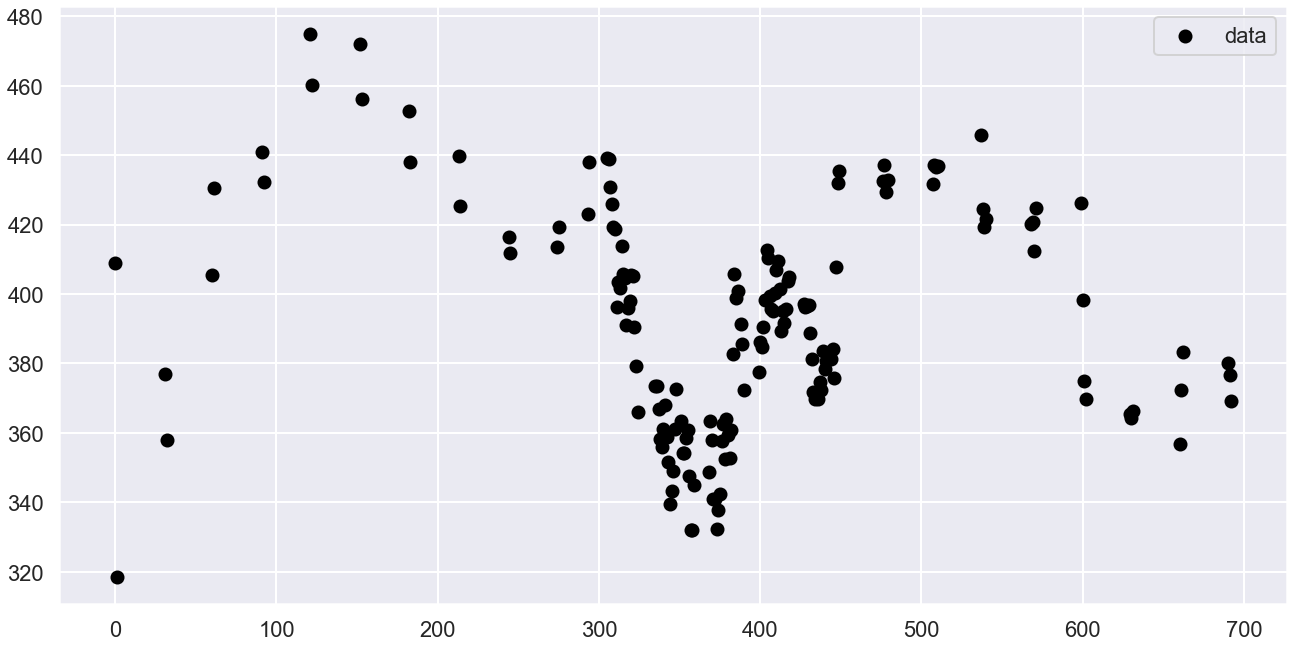

In [29]:
plt.scatter(X, y, color="black", label="data")
plt.legend(loc="best")

## Linear Regression

In [16]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [17]:
y_pred = regr.predict(X)
y_unknown = regr.predict(X_unknown)

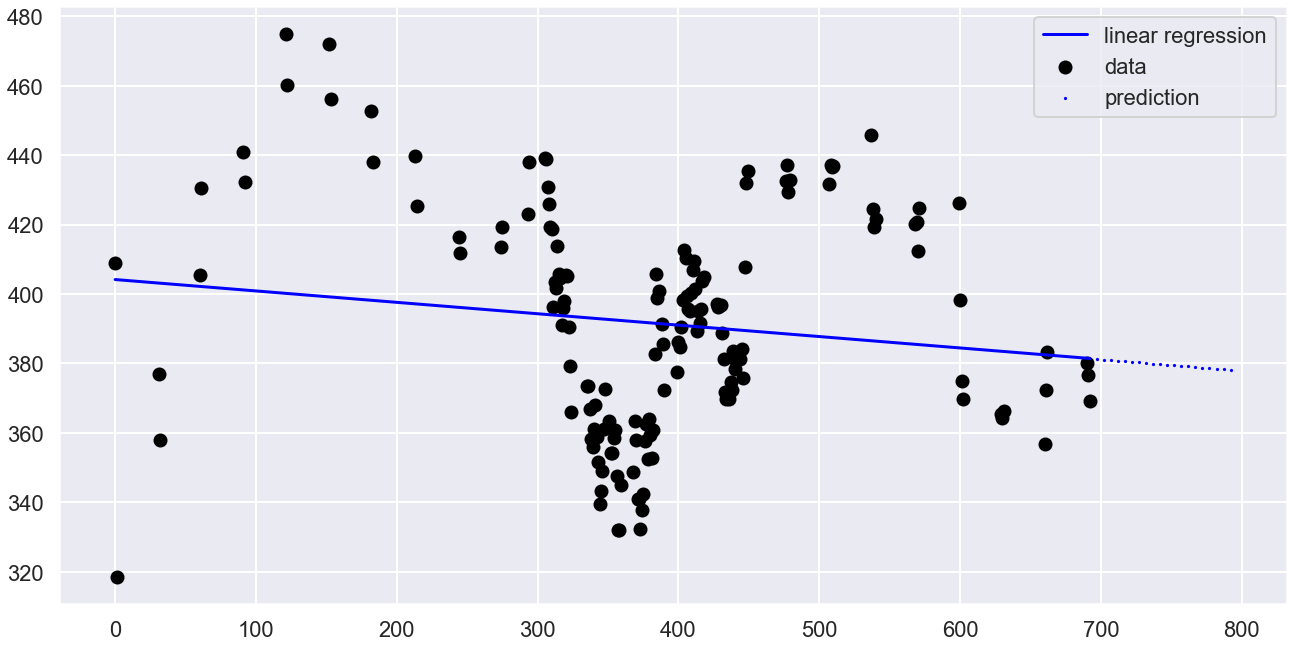

In [30]:
# Plot outputs
plt.scatter(X, y, color="black", label="data")
plt.scatter(X_unknown, y_unknown, s=1.5, color="blue", label="prediction")
plt.plot(X, y_pred, color="blue", linewidth=3, label="linear regression")
plt.legend(loc="best")

## Other Regression

In [19]:
# Train classifiers
reg2 = GradientBoostingRegressor(random_state=1)
reg3 = RandomForestRegressor(random_state=1)

reg2.fit(X, y)
reg3.fit(X, y)

C:\Users\enzom\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=1, verbose=0,
                      warm_start=False)

In [20]:
y_pred_2 = reg2.predict(X)
y_pred_3 = reg3.predict(X)

y_unknown_2 = reg2.predict(X_unknown)
y_unknown_3 = reg3.predict(X_unknown)

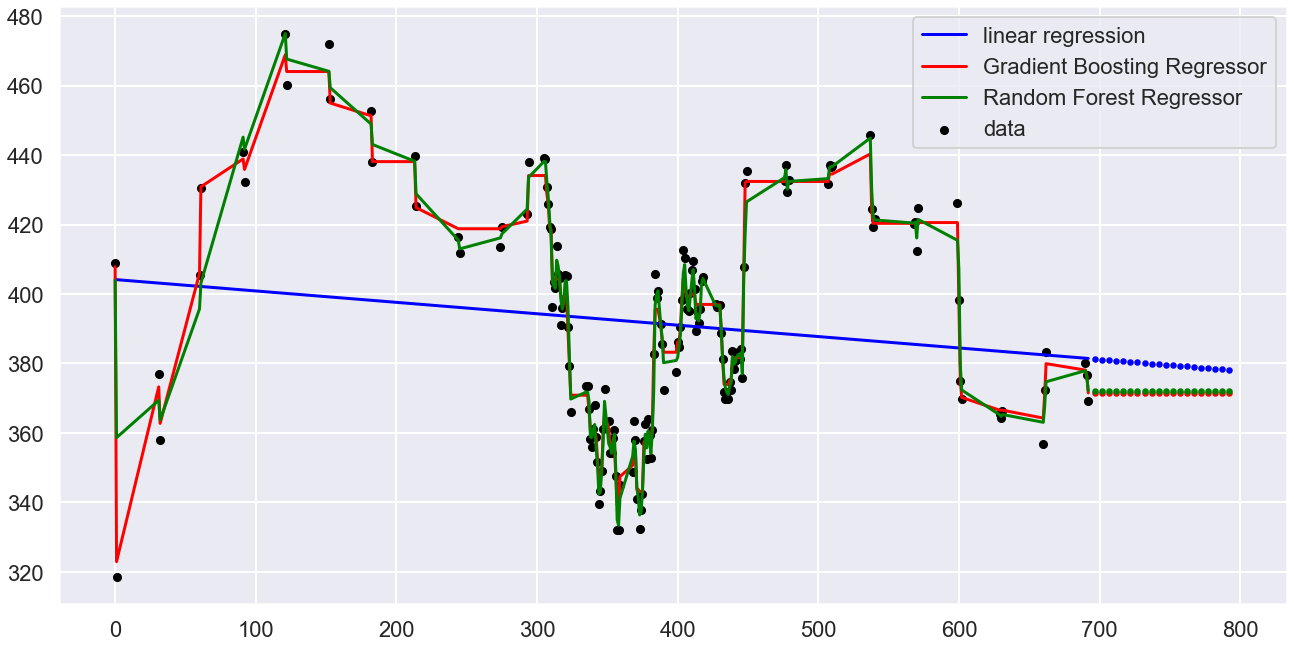

In [31]:
# Plot outputs
plt.scatter(X, y, color="black", s=50, label="data")
plt.scatter(X_unknown, y_unknown, s=20, color="blue")
plt.scatter(X_unknown, y_unknown_2, s=20, color="red")
plt.scatter(X_unknown, y_unknown_3, s=20, color="green")
plt.plot(X, y_pred, color="blue", linewidth=3, label="linear regression")
plt.plot(X, y_pred_2, color="red", linewidth=3, label="Gradient Boosting Regressor")
plt.plot(X, y_pred_3, color="green", linewidth=3, label="Random Forest Regressor")
plt.legend(loc="best")

## SVR

In [33]:
reg4 = make_pipeline(StandardScaler(), SVR(degree = 1, C=1.0, epsilon=0.2))
reg5 = make_pipeline(StandardScaler(), SVR(degree = 2, C=1.0, epsilon=0.2))
reg6 = make_pipeline(StandardScaler(), SVR(degree = 3, C=1.0, epsilon=0.2))

reg4.fit(X, y)
reg5.fit(X, y)
reg6.fit(X, y)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [34]:
y_pred_4 = reg4.predict(X)
y_pred_5 = reg5.predict(X)
y_pred_6 = reg6.predict(X)

y_unknown_4 = reg4.predict(X_unknown)
y_unknown_5 = reg5.predict(X_unknown)
y_unknown_6 = reg6.predict(X_unknown)

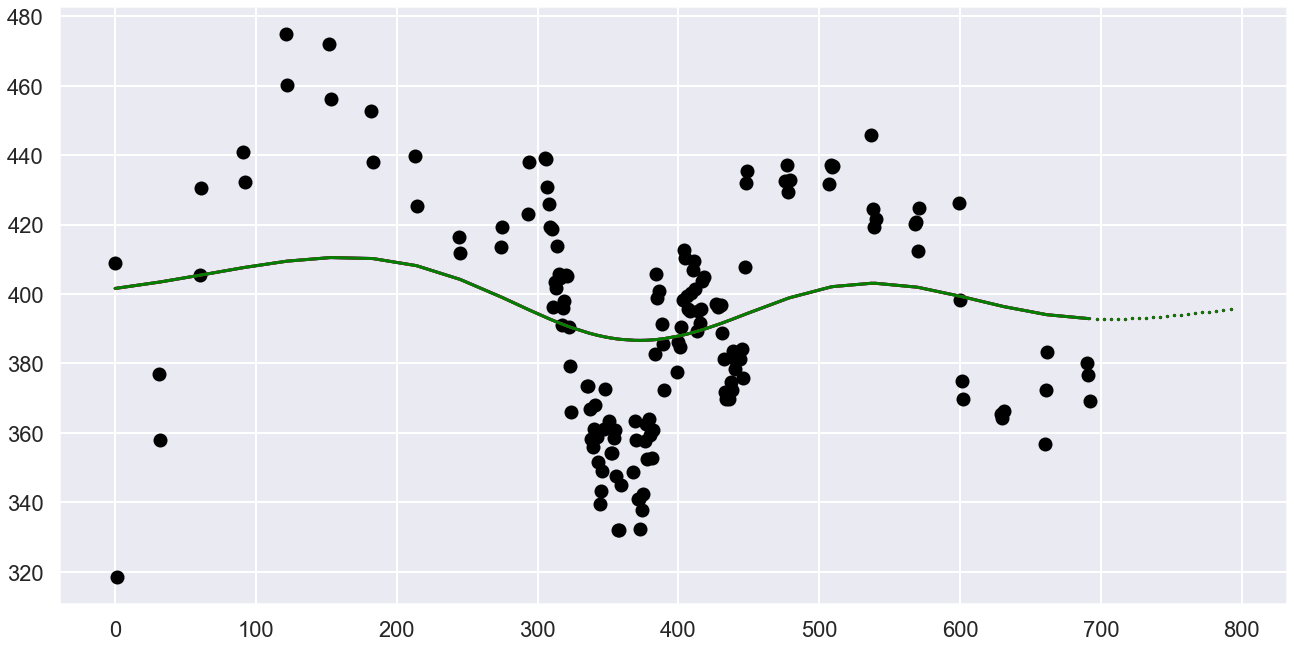

In [35]:
# Plot outputs
plt.scatter(X, y, color="black", label="data")
plt.scatter(X_unknown, y_unknown_4, s=1.5, color="blue")
plt.scatter(X_unknown, y_unknown_5, s=1.5, color="red")
plt.scatter(X_unknown, y_unknown_6, s=1.5, color="green")
plt.plot(X, y_pred_4, color="blue", linewidth=3, label="SVR 3")
plt.plot(X, y_pred_5, color="red", linewidth=3, label="SVR 5")
plt.plot(X, y_pred_6, color="green", linewidth=3, label="SVR 9")